# AMS 516 - Optimal Excution Under Market Impact

1(a). Empirical Evaluation of the Baseline Parameters

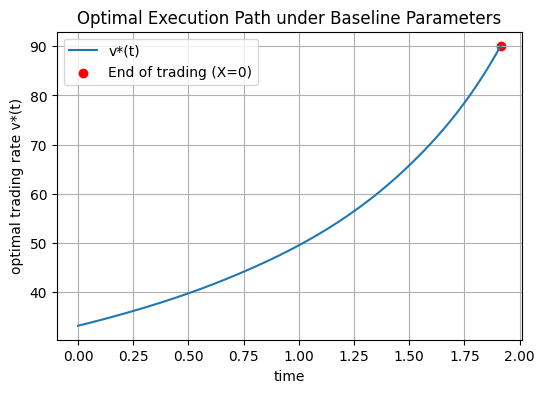

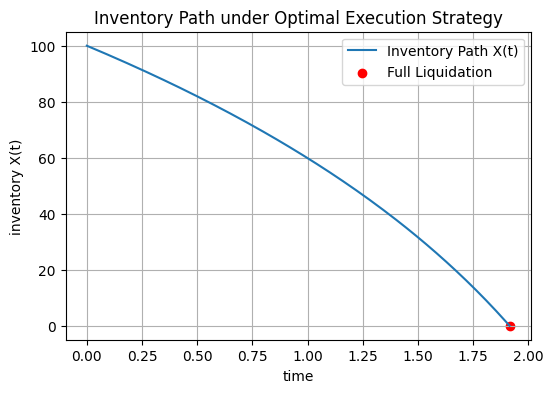

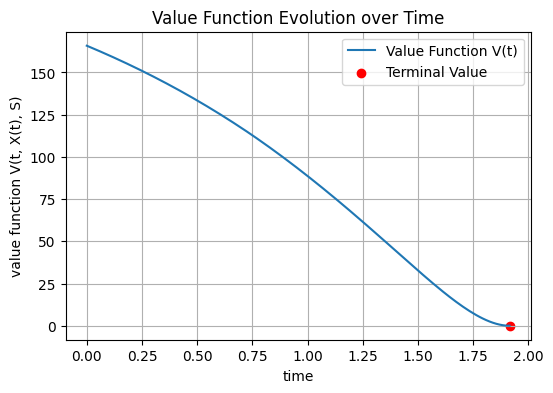


==================== ANALYTIC REFERENCE ARRAYS ====================

t_ref = np.array([
    0.0000000000, 0.0150753769, 0.0301507538, 0.0452261307, 0.0603015075, 0.0753768844, 0.0904522613, 0.1055276382, 0.1206030151, 0.1356783920, 0.1507537688, 0.1658291457, 0.1809045226, 0.1959798995, 0.2110552764, 0.2261306533, 0.2412060302, 0.2562814070, 0.2713567839, 0.2864321608, 0.3015075377, 0.3165829146, 0.3316582915, 0.3467336683, 0.3618090452, 0.3768844221, 0.3919597990, 0.4070351759, 0.4221105528, 0.4371859296, 0.4522613065, 0.4673366834, 0.4824120603, 0.4974874372, 0.5125628141, 0.5276381910, 0.5427135678, 0.5577889447, 0.5728643216, 0.5879396985, 0.6030150754, 0.6180904523, 0.6331658291, 0.6482412060, 0.6633165829, 0.6783919598, 0.6934673367, 0.7085427136, 0.7236180905, 0.7386934673, 0.7537688442, 0.7688442211, 0.7839195980, 0.7989949749, 0.8140703518, 0.8291457286, 0.8442211055, 0.8592964824, 0.8743718593, 0.8894472362, 0.9045226131, 0.9195979899, 0.9346733668, 0.9497487437, 0.964824120

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# parameters
sigma = 0.2
eta = 0.05
lam = 0.1
T = 3.0
X_target = 0.0

# terminal conditions
A_T, B_T, C_T = 3.0, 0.0, 0.0
D_T, E_T, F_T = -X_target, 0.0, 0.5 * X_target**2

# def of the ODE system
def ode_system(t, y):
    A, B, C, D, E, F = y
    alpha = A + eta * B
    beta = B + eta * C
    gamma = D + eta * E

    dA = (1/lam) * alpha**2
    dB = (1/lam) * alpha * beta
    dC = (1/lam) * beta**2
    dD = (1/lam) * alpha * gamma
    dE = (1/lam) * beta * gamma
    dF = (1/(2*lam)) * gamma**2 - 0.5 * sigma**2 * C
    return [dA, dB, dC, dD, dE, dF]

# Integrate backwards from t=T to t=0
t_span = [T, 0]
y0 = [A_T, B_T, C_T, D_T, E_T, F_T]

# evaluate solution at 200 points between T and 0
sol = solve_ivp(ode_system, t_span, y0, t_eval=np.linspace(T, 0, 200))
A, B, C, D, E, F = sol.y
t = sol.t

# reverse arrays so time increases from 0 to T for plotting
t = t[::-1]
A, B, C, D, E, F = [arr[::-1] for arr in [A, B, C, D, E, F]]

# compute optimal control and value function
X0, S0 = 100.0, 20.0  
V_X = A * X0 + B * S0 + D
V_S = B * X0 + C * S0 + E
v_star = (V_X + eta * V_S) / lam


# simulate inventory path X_t under optimal control
dt = np.diff(t)
X_path = [X0]
stop_index = len(dt)  

for i in range(len(dt)):
    X_next = X_path[-1] - v_star[i] * dt[i]
    X_path.append(X_next)
    if X_next <= X_target:  
        stop_index = i + 1
        break

# trim all arrays to the point of full liquidation
X_path = np.array(X_path[:stop_index + 1])
t = t[:stop_index + 1]
v_star = v_star[:stop_index + 1]
A, B, C, D, E, F = [arr[:stop_index + 1] for arr in [A, B, C, D, E, F]]

# vompute value function V(t, X_t, S0) along the path
V_path = 0.5 * A * X_path**2 + B * X_path * S0 + 0.5 * C * S0**2 + D * X_path + E * S0 + F

# plot optimal trading rate
plt.figure(figsize=(6,4))
plt.plot(t, v_star, label="v*(t)")
plt.scatter(t[-1], v_star[-1], color='red', label="End of trading (X=0)")
plt.xlabel("time")
plt.ylabel("optimal trading rate v*(t)")
plt.title("Optimal Execution Path under Baseline Parameters")
plt.legend()
plt.grid(True)
plt.show()

# plot inventory path 
plt.figure(figsize=(6,4))
plt.plot(t, X_path, label="Inventory Path X(t)")
plt.scatter(t[-1], X_path[-1], color='red', label="Full Liquidation")
plt.xlabel("time")
plt.ylabel("inventory X(t)")
plt.title("Inventory Path under Optimal Execution Strategy")
plt.legend()
plt.grid(True)
plt.show()

# plot value function over time
plt.figure(figsize=(6,4))
plt.plot(t, V_path, label="Value Function V(t)")
plt.scatter(t[-1], V_path[-1], color='red', label="Terminal Value")
plt.xlabel("time")
plt.ylabel("value function V(t, X(t), S)")
plt.title("Value Function Evolution over Time")
plt.legend()
plt.grid(True)
plt.show()

# analytical solution values over the time interval of execution

def print_array(name, arr, digits=10):
    arr_str = ", ".join([f"{x:.{digits}f}" for x in arr])
    print(f"\n{name} = np.array([\n    {arr_str}\n])")

print("\n==================== ANALYTIC REFERENCE ARRAYS ====================")

print_array("t_ref", t)
print_array("V_ref", V_path)
print_array("v_ref", v_star)
print_array("X_ref", X_path)

print("\n(PRINT THESE INTO THE PINN EVALUATION PROGRAM)")








1(b). Neural Network Approach for Solving the equation (Baseline Parameters)

In [ ]:
# Baseline Parameters neural network approach

import numpy as np
import torch
import torch.nn as nn
import time
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float64)

# analytic problem parameters 
sigma = 0.2
eta   = 0.05
lam   = 0.1
T     = 1.0
X_target = 0.0
X_max = 100.0
S_max = 20.0 

V_max = 0.5 * (X_max**2)
V_scale = V_max   

# analyical solution functions
def solve_riccati_coeffs(sigma, eta, lam, T,
                         A_T=1.0, B_T=0.0, C_T=0.0,
                         D_T=None, E_T=0.0, F_T=None,
                         n_points=2001):
    if D_T is None: D_T = -X_target
    if F_T is None: F_T = 0.5*(X_target**2)
    def ode_system(t, y):
        A,B,C,D,E,F = y
        alpha = A + eta*B
        beta  = B + eta*C
        gamma = D + eta*E
        dA = (alpha**2)/lam
        dB = (alpha*beta)/lam
        dC = (beta**2)/lam
        dD = (alpha*gamma)/lam
        dE = (beta*gamma)/lam
        dF = (gamma**2)/(2*lam) - 0.5*sigma**2*C
        return [dA,dB,dC,dD,dE,dF]
    t_eval = np.linspace(T,0.0,n_points)
    y0 = [A_T,B_T,C_T,D_T,E_T,F_T]
    sol = solve_ivp(ode_system,[T,0.0],y0,t_eval=t_eval,rtol=1e-9,atol=1e-12)
    t_sol = sol.t[::-1]
    A,B,C,D,E,F = [arr[::-1] for arr in sol.y]
    A_fun = interp1d(t_sol,A,kind='cubic',fill_value="extrapolate")
    B_fun = interp1d(t_sol,B,kind='cubic',fill_value="extrapolate")
    C_fun = interp1d(t_sol,C,kind='cubic',fill_value="extrapolate")
    D_fun = interp1d(t_sol,D,kind='cubic',fill_value="extrapolate")
    E_fun = interp1d(t_sol,E,kind='cubic',fill_value="extrapolate")
    F_fun = interp1d(t_sol,F,kind='cubic',fill_value="extrapolate")
    return A_fun,B_fun,C_fun,D_fun,E_fun,F_fun

A_fun,B_fun,C_fun,D_fun,E_fun,F_fun = solve_riccati_coeffs(sigma,eta,lam,T)

def analytic_V_and_derivs(t_phys,X_phys,S_phys):
    t_arr = np.atleast_1d(t_phys)
    A = A_fun(t_arr); B = B_fun(t_arr); C = C_fun(t_arr)
    D = D_fun(t_arr); E = E_fun(t_arr); F = F_fun(t_arr)
    X_arr = np.atleast_1d(X_phys)
    S_arr = np.atleast_1d(S_phys)
    if X_arr.size==1 and t_arr.size>1: X_arr = np.full_like(t_arr,float(X_arr))
    if S_arr.size==1 and t_arr.size>1: S_arr = np.full_like(t_arr,float(S_arr))
    V = 0.5*A*X_arr**2 + B*X_arr*S_arr + 0.5*C*S_arr**2 + D*X_arr + E*S_arr + F
    V_X = A*X_arr + B*S_arr + D
    V_S = B*X_arr + C*S_arr + E
    V_SS = C
    alpha = A + eta*B
    beta  = B + eta*C
    gamma = D + eta*E
    dA = (alpha**2)/lam
    dB = (alpha*beta)/lam
    dC = (beta**2)/lam
    dD = (alpha*gamma)/lam
    dE = (beta*gamma)/lam
    dF = (gamma**2)/(2*lam) - 0.5*sigma**2*C
    V_t = 0.5*dA*X_arr**2 + dB*X_arr*S_arr + 0.5*dC*S_arr**2 + dD*X_arr + dE*S_arr + dF
    if np.isscalar(t_phys):
        return float(V),float(V_X),float(V_S),float(V_t),float(V_SS)
    return V,V_X,V_S,V_t,V_SS

# normalization functions
def normalize_t(t): return t / T
def normalize_X(X): return X / X_max
def normalize_S(S): return S / S_max

# PINN class
class PINN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.act = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            L = nn.Linear(layers[i],layers[i+1])
            nn.init.xavier_uniform_(L.weight)
            nn.init.zeros_(L.bias)
            self.layers.append(L)
    def base_NN(self,t_norm,X_norm,S_norm):
        x = torch.cat([t_norm,X_norm,S_norm],dim=1)
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        return self.layers[-1](x)
    def forward(self,t,X,S):
        t_norm = normalize_t(t)
        X_norm = normalize_X(X)
        S_norm = normalize_S(S)
        NN_out = self.base_NN(t_norm,X_norm,S_norm)
        V_T_phys = 0.5*(X - X_target)**2
        V_T_scaled = V_T_phys / V_scale
        return (1.0 - t)*NN_out + t*V_T_scaled

# PDE loss function
def compute_pde_loss(model,t_f,X_f,S_f):
    t = t_f.clone().detach().requires_grad_(True)
    X = X_f.clone().detach().requires_grad_(True)
    S = S_f.clone().detach().requires_grad_(True)

    V_scaled = model(t,X,S)
    V = V_scaled * V_scale

    V_t = torch.autograd.grad(V,t,torch.ones_like(V),create_graph=True)[0]
    V_X = torch.autograd.grad(V,X,torch.ones_like(V),create_graph=True)[0]
    V_S = torch.autograd.grad(V,S,torch.ones_like(V),create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S,S,torch.ones_like(V_S),create_graph=True)[0]

    residual = V_t + 0.5/lam*(V_X + eta*V_S)**2 + 0.5*sigma**2*V_SS
    residual_norm = residual / (1.0 + torch.abs(V_X) + torch.abs(V_S))

    return torch.mean(residual_norm**2)

# supervised sampling
def sample_supervised(Ns, device, t_frac=0.8):
    t_s = (np.random.rand(Ns)**0.5) * (t_frac * T)
    X_s = (np.random.rand(Ns)**0.5) * X_max
    S_s = np.random.rand(Ns) * S_max
    V_true, VX_true, VS_true, _, _ = analytic_V_and_derivs(t_s,X_s,S_s)

    # derivatives from supervised pretrain
    t_t = torch.tensor(t_s.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)
    X_t = torch.tensor(X_s.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)
    S_t = torch.tensor(S_s.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)

    return (
        t_t, X_t, S_t,
        torch.tensor(V_true.reshape(-1,1)/V_scale, dtype=torch.float64, device=device),
        torch.tensor(VX_true.reshape(-1,1)/V_scale, dtype=torch.float64, device=device),
        torch.tensor(VS_true.reshape(-1,1)/V_scale, dtype=torch.float64, device=device)
    )

# collocation sampling
def sample_collocation(Nf,device, t_frac=1.0):
    t = torch.rand((Nf,1),device=device) * (t_frac * T)
    X = torch.rand((Nf,1),device=device) * X_max
    S = torch.rand((Nf,1),device=device) * S_max
    return t,X,S

# anchor sampling
def sample_anchors(Ns_anchor, N0_anchor, device, t_frac=0.8):
    # clustered anchors near t=0
    t_s = (np.random.rand(Ns_anchor)**0.5) * (t_frac * T)
    X_s = (np.random.rand(Ns_anchor)**0.5) * X_max
    S_s = np.random.rand(Ns_anchor) * S_max
    V_true_s, VX_true_s, VS_true_s, _, _ = analytic_V_and_derivs(t_s,X_s,S_s)

    t_s_t = torch.tensor(t_s.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    X_s_t = torch.tensor(X_s.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    S_s_t = torch.tensor(S_s.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)

    V_scaled_s = torch.tensor(V_true_s.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VX_scaled_s = torch.tensor(VX_true_s.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VS_scaled_s = torch.tensor(VS_true_s.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)

    # t=0 anchors
    t0_arr = np.zeros(N0_anchor)
    X0_arr = np.linspace(0.0, X_max, N0_anchor)
    S0_arr = np.linspace(0.0, S_max, N0_anchor)
    V0_true, VX0_true, VS0_true, _, _ = analytic_V_and_derivs(t0_arr, X0_arr, S0_arr)

    t0_t = torch.tensor(t0_arr.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    X0_t = torch.tensor(X0_arr.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    S0_t = torch.tensor(S0_arr.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)

    V0_scaled = torch.tensor(V0_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VX0_scaled = torch.tensor(VX0_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VS0_scaled = torch.tensor(VS0_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)

    return (t_s_t,X_s_t,S_s_t,V_scaled_s,VX_scaled_s,VS_scaled_s,
            t0_t,X0_t,S0_t,V0_scaled,VX0_scaled,VS0_scaled)

# midtime anchors 
def sample_mid_supervised(Nmid, device, t_lo=0.3, t_hi=0.8):
    t_s = np.random.rand(Nmid) * (t_hi - t_lo) + t_lo
    X_s = (np.random.rand(Nmid)**0.5) * X_max
    S_s = np.random.rand(Nmid) * S_max
    V_true, VX_true, VS_true, _, _ = analytic_V_and_derivs(t_s, X_s, S_s)
    return (torch.tensor(t_s.reshape(-1,1),dtype=torch.float64,device=device),
            torch.tensor(X_s.reshape(-1,1),dtype=torch.float64,device=device),
            torch.tensor(S_s.reshape(-1,1),dtype=torch.float64,device=device),
            torch.tensor(V_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device))

# network hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

model = PINN([3,128,128,128,128,1]).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

pre_epochs = 1000
Ns = 3000
grad_clip = 0.1

pde_epochs = 3000
pde_batch = 16000

Ns_anchor = 2600
N0_anchor = 1000
w_anchor0 = 400.0
w_anchor_cluster = 500.0
w_t = 3.0
p = 2.0
t_cap_frac = 0.8

# supervised pretraining 
print("Starting supervised pretraining...")
t0 = time.time()
for ep in range(pre_epochs):
    t_s,X_s,S_s,V_scaled_tgt,VX_scaled_tgt,VS_scaled_tgt = sample_supervised(Ns,device,t_frac=0.8)
    V_scaled_pred = model(t_s,X_s,S_s)
    V_X_pred_scaled = torch.autograd.grad(V_scaled_pred,X_s,torch.ones_like(V_scaled_pred),create_graph=True)[0]
    V_S_pred_scaled = torch.autograd.grad(V_scaled_pred,S_s,torch.ones_like(V_scaled_pred),create_graph=True)[0]
    loss_val = torch.mean((V_scaled_pred - V_scaled_tgt)**2)
    loss_X   = torch.mean((V_X_pred_scaled - VX_scaled_tgt)**2)
    loss_S   = torch.mean((V_S_pred_scaled - VS_scaled_tgt)**2)
    loss_sup = loss_val + 0.5*loss_X + 0.5*loss_S
    optimizer.zero_grad()
    loss_sup.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
    optimizer.step()
    if ep % 100 == 0:
        print(f"Pretrain {ep}/{pre_epochs} sup_loss={loss_sup.item():.4e}")
print("Supervised pretraining finished. Time:",time.time()-t0)

# PDE training
pde_weight = 0.6
print("Starting PDE training (Adam)...")
t1 = time.time()
for ep in range(pde_epochs):
    t_f, X_f, S_f = sample_collocation(pde_batch,device, t_frac=1.0)
    loss_pde = pde_weight * compute_pde_loss(model, t_f, X_f, S_f)

    (t_s_a, X_s_a, S_s_a, V_scaled_s_a, VX_scaled_s_a, VS_scaled_s_a,
     t0_t, X0_t, S0_t, V0_scaled, VX0_scaled, VS0_scaled) = sample_anchors(Ns_anchor, N0_anchor, device, t_frac=0.8)

    V_scaled_pred_a = model(t_s_a, X_s_a, S_s_a)
    loss_sup_anchor = torch.mean((V_scaled_pred_a - V_scaled_s_a)**2)

    V0_pred = model(t0_t, X0_t, S0_t)
    loss_anchor_t0 = torch.mean((V0_pred - V0_scaled)**2)

    t_mid, X_mid, S_mid, Vmid_scaled = sample_mid_supervised(4600, device)
    Vmid_pred = model(t_mid, X_mid, S_mid)
    loss_mid = torch.mean((Vmid_pred - Vmid_scaled)**2)

    loss = loss_pde + w_anchor_cluster*loss_sup_anchor + w_anchor0*loss_anchor_t0 + 300.0*loss_mid

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()

    if ep % 200 == 0:
        print(f"PDE {ep}/{pde_epochs} loss={loss.item():.4e} (pde={loss_pde.item():.4e} anchor_cluster={loss_sup_anchor.item():.4e} anchor_t0={loss_anchor_t0.item():.4e})")
print("PDE training (Adam) finished. Time:",time.time()-t1)

# LBFGS refinement (not used, causes destabilization in results)
print("Starting LBFGS refine...")
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),max_iter=500,lr=1.0)
t_test, X_test, S_test = sample_collocation(4000, device, t_frac=1.0)
t_test.requires_grad_(True)
X_test.requires_grad_(True)
S_test.requires_grad_(True)

residual_val = compute_pde_loss(model, t_test, X_test, S_test).item()

if residual_val < 50:
    def closure():
        optimizer_lbfgs.zero_grad()
        t_f_lb, X_f_lb, S_f_lb = sample_collocation(6000, device, t_frac=1.0)
        t_f_lb.requires_grad_(True)
        X_f_lb.requires_grad_(True)
        S_f_lb.requires_grad_(True)
        loss_lb = pde_weight * compute_pde_loss(model, t_f_lb, X_f_lb, S_f_lb)
        loss_lb.backward()
        return loss_lb
    optimizer_lbfgs.step(closure)
    print("LBFGS refine finished.")
else:
    print(f"LBFGS skipped: PDE residual too large ({residual_val:.4f})")




    

# PINN evaluation at t_ref 
model.eval()

t_ref = np.array([
    0.0000000000, 0.0050251256, 0.0100502513, 0.0150753769, 0.0201005025, 0.0251256281, 0.0301507538, 0.0351758794, 0.0402010050, 0.0452261307, 0.0502512563, 0.0552763819, 0.0603015075, 0.0653266332, 0.0703517588, 0.0753768844, 0.0804020101, 0.0854271357, 0.0904522613, 0.0954773869, 0.1005025126, 0.1055276382, 0.1105527638, 0.1155778894, 0.1206030151, 0.1256281407, 0.1306532663, 0.1356783920, 0.1407035176, 0.1457286432, 0.1507537688, 0.1557788945, 0.1608040201, 0.1658291457, 0.1708542714, 0.1758793970, 0.1809045226, 0.1859296482, 0.1909547739, 0.1959798995, 0.2010050251, 0.2060301508, 0.2110552764, 0.2160804020, 0.2211055276, 0.2261306533, 0.2311557789, 0.2361809045, 0.2412060302, 0.2462311558, 0.2512562814, 0.2562814070, 0.2613065327, 0.2663316583, 0.2713567839, 0.2763819095, 0.2814070352, 0.2864321608, 0.2914572864, 0.2964824121, 0.3015075377, 0.3065326633, 0.3115577889, 0.3165829146, 0.3216080402, 0.3266331658, 0.3316582915, 0.3366834171, 0.3417085427, 0.3467336683, 0.3517587940, 0.3567839196, 0.3618090452, 0.3668341709, 0.3718592965, 0.3768844221, 0.3819095477, 0.3869346734, 0.3919597990, 0.3969849246, 0.4020100503, 0.4070351759, 0.4120603015, 0.4170854271, 0.4221105528, 0.4271356784, 0.4321608040, 0.4371859296, 0.4422110553, 0.4472361809, 0.4522613065, 0.4572864322, 0.4623115578, 0.4673366834, 0.4723618090, 0.4773869347, 0.4824120603, 0.4874371859, 0.4924623116, 0.4974874372, 0.5025125628, 0.5075376884, 0.5125628141, 0.5175879397, 0.5226130653, 0.5276381910, 0.5326633166, 0.5376884422, 0.5427135678, 0.5477386935, 0.5527638191, 0.5577889447, 0.5628140704, 0.5678391960, 0.5728643216, 0.5778894472, 0.5829145729, 0.5879396985, 0.5929648241, 0.5979899497, 0.6030150754, 0.6080402010, 0.6130653266, 0.6180904523, 0.6231155779, 0.6281407035, 0.6331658291, 0.6381909548, 0.6432160804, 0.6482412060, 0.6532663317, 0.6582914573, 0.6633165829, 0.6683417085, 0.6733668342, 0.6783919598, 0.6834170854, 0.6884422111, 0.6934673367, 0.6984924623
])
V_ref = np.array([
    456.6175819537, 454.5212976697, 452.4041458529, 450.2660651075, 448.1069922893, 445.9268622868, 443.7256078089, 441.5031591799, 439.2594441419, 436.9943876650, 434.7079117664, 432.3999353364, 430.0703739752, 427.7191398373, 425.3461414865, 422.9512837603, 420.5344676448, 418.0955901607, 415.6345442603, 413.1512187361, 410.6454981414, 408.1172627245, 405.5663883747, 402.9927465827, 400.3962044157, 397.7766245060, 395.1338650563, 392.4677798600, 389.7782183391, 387.0650255984, 384.3280424982, 381.5671057460, 378.7820480069, 375.9726980349, 373.1388808251, 370.2804177873, 367.3971269428, 364.4888231448, 361.5553183236, 358.5964217565, 355.6119403652, 352.6016790407, 349.5654409962, 346.5030281510, 343.4142415446, 340.2988817835, 337.1567495211, 333.9876459736, 330.7913734709, 327.5677360459, 324.3165400633, 321.0375948883, 317.7307135987, 314.3957137402, 311.0324181282, 307.6406556963, 304.2202623959, 300.7710821449, 297.2929678322, 293.7857823761, 290.2493998410, 286.6837066141, 283.0886026445, 279.4640027465, 275.8098379710, 272.1260570457, 268.4126278892, 264.6695288018, 260.8941376150, 257.0850533518, 253.2431953066, 249.3694599592, 245.4647224708, 241.5298383364, 237.5656451996, 233.5729648364, 229.5526053164, 225.5053633476, 221.4320268139, 217.3333775144, 213.2101941120, 209.0632553028, 204.8933432155, 200.7012470522, 196.4877669811, 192.2537182949, 187.9999358466, 183.7272787753, 179.4366355391, 175.1289292676, 170.8051234505, 166.4662279804, 162.1133055660, 157.7474785349, 153.3699360462, 148.9819417323, 144.5848417940, 140.1800735689, 135.7691746001, 131.3537922291, 126.9356937396, 122.5167770815, 118.0990822035, 113.6848030255, 109.2763000851, 104.8761138897, 100.4869790127, 96.1118389705, 91.7538619199, 87.4164572181, 83.1032928884, 78.8183140375, 74.5657622732, 70.3501961710, 66.1765128448, 62.0499706743, 57.9762132493, 53.9612945893, 50.0117057042, 46.1343663384, 42.3357666551, 38.6240804741, 35.0085380603, 31.4987668239, 28.1048417402, 24.8373398962, 21.7073994282, 18.7267831338, 15.9079470670, 13.2641144473, 10.8093552432, 8.5586718167, 6.5280910469, 4.7347633842, 3.1970693204, 1.9347337979, 0.9689491219, 0.3225069820, 0.0199402341, 0.0876751450
])
v_ref = np.array([
    91.3235163907, 91.7443795904, 92.1688232589, 92.5969137187, 93.0287187592, 93.4643076369, 93.9037510756, 94.3471212661, 94.7944918663, 95.2459380013, 95.7015362633, 96.1613647115, 96.6255028725, 97.0940317399, 97.5670337742, 98.0445929033, 98.5267945221, 99.0137254928, 99.5054741444, 100.0021302734, 100.5037851431, 101.0105314841, 101.5224634941, 102.0396768379, 102.5622686474, 103.0903375217, 103.6239835270, 104.1633081966, 104.7084145308, 105.2594069973, 105.8163915308, 106.3794755329, 106.9487678728, 107.5243788864, 108.1064203768, 108.6950056145, 109.2902493368, 109.8922677482, 110.5011785205, 111.1171007925, 111.7401551700, 112.3704637261, 113.0081500010, 113.6533390020, 114.3061572034, 114.9667325469, 115.6351944411, 116.3116737618, 116.9963028520, 117.6892155216, 118.3905470478, 119.1004341749, 119.8190151143, 120.5464295446, 121.2828186115, 122.0283249276, 122.7830925730, 123.5472670946, 124.3209955067, 125.1044262905, 125.8977093943, 126.7009962339, 127.5144396917, 128.3381941176, 129.1724153285, 130.0172606084, 130.8728887085, 131.7394546718, 132.6157811983, 133.5011694519, 134.3960461040, 135.3008432351, 136.2159983357, 137.1419543055, 138.0791594541, 139.0280675005, 139.9891375734, 140.9628342109, 141.9496273607, 142.9499923803, 143.9644100366, 144.9933665060, 146.0373533746, 147.0968676381, 148.1724117018, 149.2644933804, 150.3736258983, 151.5003278894, 152.6451233974, 153.8085418753, 154.9911181858, 156.1933926012, 157.4159108033, 158.6592238836, 159.9238883430, 161.2104660921, 162.5195244511, 163.8516361497, 165.2073793272, 166.5873375325, 167.9920997240, 169.4222602697, 170.8784189474, 172.3611809441, 173.8711568566, 175.4089626914, 176.9752198642, 178.5705552006, 180.1956009356, 181.8509947139, 183.5373795898, 185.2554040270, 187.0057218989, 188.7889924885, 190.6058804882, 192.4570560002, 194.3431945362, 196.2649770175, 198.2230897748, 200.2180673501, 202.2459566959, 204.3064574892, 206.4018816983, 208.5345838781, 210.7069611693, 212.9214532989, 215.1805425803, 217.4867539127, 219.8426547816, 222.2508552587, 224.7140080018, 227.2348082550, 229.8159938484, 232.4603451984, 235.1706853073, 237.9498797639, 240.8008367429, 243.7265070054, 246.7298838984, 249.8140033553
])
X_ref = np.array([
    100.0000000000, 99.5410878573, 99.0800608242, 98.6169009083, 98.1515897841, 97.6841087853, 97.2144388977, 96.7425607516, 96.2684546146, 95.7921003841, 95.3134775801, 94.8325653376, 94.3493423993, 93.8637871085, 93.3758774012, 92.8855907994, 92.3929044029, 91.8977948827, 91.4002384731, 90.9002109649, 90.3976876972, 89.8926435507, 89.3850529403, 88.8748898071, 88.3621276120, 87.8467393273, 87.3286974302, 86.8079738949, 86.2845401854, 85.7583672480, 85.2294255043, 84.6976848434, 84.1631146145, 83.6256836202, 83.0853601082, 82.5421117646, 81.9959057063, 81.4467084734, 80.8944860224, 80.3392037183, 79.7808263274, 79.2193180099, 78.6546423128, 78.0867621621, 77.5156398555, 76.9412370555, 76.3635147814, 75.7824334023, 75.1979526296, 74.6100315098, 74.0186284167, 73.4237010446, 72.8252064005, 72.2231007969, 71.6173398444, 71.0078784444, 70.3946707814, 69.7776703162, 69.1568297780, 68.5321011574, 67.9034356987, 67.2707838927, 66.6340954694, 65.9933193905, 65.3484038422, 64.6992962275, 64.0459431591, 63.3882904520, 62.7262831421, 62.0598721813, 61.3890120333, 60.7136550177, 60.0337512829, 59.3492487787, 58.6600932294, 57.9662281065, 57.2675946015, 56.5641315986, 55.8557756478, 55.1424609374, 54.4241192672, 53.7006800208, 52.9720701388, 52.2382140917, 51.4990338523, 50.7544488689, 50.0043760379, 49.2487296766, 48.4874214962, 47.7203605746, 46.9474533290, 46.1686034889, 45.3837120688, 44.5926773411, 43.7953948090, 42.9917571792, 42.1816543345, 41.3649733071, 40.5415982511, 39.7114104152, 38.8742881161, 38.0301067104, 37.1787385684, 36.3200530460, 35.4539164584, 34.5801920521, 33.6987399782, 32.8094172654, 31.9120777920, 31.0065722596, 30.0927481656, 29.1704497757, 28.2395180972, 27.2997908515, 26.3511024470, 25.3932839521, 24.4261630676, 23.4495641001, 22.4633079342, 21.4672120057, 20.4610910642, 19.4447797241, 18.4181141085, 17.3809187231, 16.3330062413, 15.2741772907, 14.2042202390, 13.1229109798, 12.0300127189, 10.9252757602, 9.8084372916, 8.6792211709, 7.5373377124, 6.3824834719, 5.2143410338, 4.0325787960, 2.8368507570, 1.6267963010, 0.4020399844, -0.8378086784
])


X0 = 100.0
S0 = 20.0

# convert t_ref to torch tensor for evaluation
t_t = torch.tensor(t_ref.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)
X_t = torch.full_like(t_t, X0, requires_grad=True)   
S_t = torch.full_like(t_t, S0, requires_grad=True)   

# evaluate PINN 
V_scaled_pred = model(t_t, X_t, S_t)
V_pred_phys = V_scaled_pred * V_scale

# compute derivatives for trading rate
V_X_pred_phys = torch.autograd.grad(V_pred_phys, X_t, torch.ones_like(V_pred_phys), create_graph=True)[0]
V_S_pred_phys = torch.autograd.grad(V_pred_phys, S_t, torch.ones_like(V_pred_phys), create_graph=True)[0]

# convert to numpy
V_pred_np = V_pred_phys.detach().cpu().numpy().flatten()
V_X_np = V_X_pred_phys.detach().cpu().numpy().flatten()
V_S_np = V_S_pred_phys.detach().cpu().numpy().flatten()
v_pred = (V_X_np + eta * V_S_np) / lam

# error metrics against analytic solution at t_ref
def compute_errors(pred, true):
    abs_err = np.abs(pred - true)
    L1 = abs_err.mean()
    rel = abs_err / np.maximum(np.abs(true), 1e-10)
    return L1, abs_err.mean(), rel.mean()

V_L1, V_abs, V_rel = compute_errors(V_pred_np, V_ref)
v_L1, v_abs, v_rel = compute_errors(v_pred, v_ref)

print("\n==================== VALUE FUNCTION ERRORS ====================")
print(f"L1 norm error:        {V_L1:.6e}")
print(f"Mean absolute error:  {V_abs:.6e}")
print(f"Mean relative error:  {V_rel:.6e}")

print("\n==================== TRADING RATE ERRORS ======================")
print(f"L1 norm error:        {v_L1:.6e}")
print(f"Mean absolute error:  {v_abs:.6e}")
print(f"Mean relative error:  {v_rel:.6e}")

# sample table based on number of t_ref values
print("\n==================== SAMPLE POINT COMPARISON ====================")
idx = np.linspace(0, len(t_ref)-1, 30).astype(int)
print(f"{'t':>6} | {'V_ref':>12} | {'V_PINN':>12} | {'v_ref':>12} | {'v_PINN':>12}")
print("-"*66)
for i in idx:
    print(f"{t_ref[i]:6.4f} | {V_ref[i]:12.6f} | {V_pred_np[i]:12.6f} | {v_ref[i]:12.6f} | {v_pred[i]:12.6f}")

print("\nDone.")



































Device: cpu
Starting supervised pretraining...
Pretrain 0/1000 sup_loss=5.4102e-02
Pretrain 100/1000 sup_loss=7.8595e-03
Pretrain 200/1000 sup_loss=6.8263e-03
Pretrain 300/1000 sup_loss=6.6610e-03
Pretrain 400/1000 sup_loss=6.8020e-03
Pretrain 500/1000 sup_loss=6.0855e-03
Pretrain 600/1000 sup_loss=3.9136e-03
Pretrain 700/1000 sup_loss=2.0788e-03
Pretrain 800/1000 sup_loss=1.3440e-03
Pretrain 900/1000 sup_loss=1.1525e-03
Supervised pretraining finished. Time: 49.274800062179565
Starting PDE training (Adam)...
PDE 0/3000 loss=2.5053e+04 (pde=2.5045e+04 anchor_cluster=1.0160e-03 anchor_t0=1.7373e-02)
PDE 200/3000 loss=1.4923e+03 (pde=1.0953e+03 anchor_cluster=4.6522e-01 anchor_t0=6.4429e-02)
PDE 400/3000 loss=1.2123e+03 (pde=8.7427e+02 anchor_cluster=4.1029e-01 anchor_t0=4.1966e-02)
PDE 600/3000 loss=7.6830e+02 (pde=5.3202e+02 anchor_cluster=2.8699e-01 anchor_t0=1.5172e-02)
PDE 800/3000 loss=6.3915e+02 (pde=4.6357e+02 anchor_cluster=2.1315e-01 anchor_t0=1.1898e-02)
PDE 1000/3000 loss=5.6

1(c). Neural Network Approach for Solving the equation (High Trading Costs)

In [ ]:
# High Trading Cost Neural Network Approach

import numpy as np
import torch
import torch.nn as nn
import time
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float64)

# parameters for high trading cost problem
sigma = 0.2
eta   = 0.05
lam   = 0.7
T     = 1.0
X_target = 0.0
X_max = 100.0
S_max = 20.0 

V_max = 0.5 * (X_max**2)
V_scale = V_max   # value function scale

# functions to solve analytic solution
def solve_riccati_coeffs(sigma, eta, lam, T,
                         A_T=1.0, B_T=0.0, C_T=0.0,
                         D_T=None, E_T=0.0, F_T=None,
                         n_points=2001):
    if D_T is None: D_T = -X_target
    if F_T is None: F_T = 0.5*(X_target**2)
    def ode_system(t, y):
        A,B,C,D,E,F = y
        alpha = A + eta*B
        beta  = B + eta*C
        gamma = D + eta*E
        dA = (alpha**2)/lam
        dB = (alpha*beta)/lam
        dC = (beta**2)/lam
        dD = (alpha*gamma)/lam
        dE = (beta*gamma)/lam
        dF = (gamma**2)/(2*lam) - 0.5*sigma**2*C
        return [dA,dB,dC,dD,dE,dF]
    t_eval = np.linspace(T,0.0,n_points)
    y0 = [A_T,B_T,C_T,D_T,E_T,F_T]
    sol = solve_ivp(ode_system,[T,0.0],y0,t_eval=t_eval,rtol=1e-9,atol=1e-12)
    t_sol = sol.t[::-1]
    A,B,C,D,E,F = [arr[::-1] for arr in sol.y]
    A_fun = interp1d(t_sol,A,kind='cubic',fill_value="extrapolate")
    B_fun = interp1d(t_sol,B,kind='cubic',fill_value="extrapolate")
    C_fun = interp1d(t_sol,C,kind='cubic',fill_value="extrapolate")
    D_fun = interp1d(t_sol,D,kind='cubic',fill_value="extrapolate")
    E_fun = interp1d(t_sol,E,kind='cubic',fill_value="extrapolate")
    F_fun = interp1d(t_sol,F,kind='cubic',fill_value="extrapolate")
    return A_fun,B_fun,C_fun,D_fun,E_fun,F_fun

A_fun,B_fun,C_fun,D_fun,E_fun,F_fun = solve_riccati_coeffs(sigma,eta,lam,T)

def analytic_V_and_derivs(t_phys,X_phys,S_phys):
    t_arr = np.atleast_1d(t_phys)
    A = A_fun(t_arr); B = B_fun(t_arr); C = C_fun(t_arr)
    D = D_fun(t_arr); E = E_fun(t_arr); F = F_fun(t_arr)
    X_arr = np.atleast_1d(X_phys)
    S_arr = np.atleast_1d(S_phys)
    if X_arr.size==1 and t_arr.size>1: X_arr = np.full_like(t_arr,float(X_arr))
    if S_arr.size==1 and t_arr.size>1: S_arr = np.full_like(t_arr,float(S_arr))
    V = 0.5*A*X_arr**2 + B*X_arr*S_arr + 0.5*C*S_arr**2 + D*X_arr + E*S_arr + F
    V_X = A*X_arr + B*S_arr + D
    V_S = B*X_arr + C*S_arr + E
    V_SS = C
    alpha = A + eta*B
    beta  = B + eta*C
    gamma = D + eta*E
    dA = (alpha**2)/lam
    dB = (alpha*beta)/lam
    dC = (beta**2)/lam
    dD = (alpha*gamma)/lam
    dE = (beta*gamma)/lam
    dF = (gamma**2)/(2*lam) - 0.5*sigma**2*C
    V_t = 0.5*dA*X_arr**2 + dB*X_arr*S_arr + 0.5*dC*S_arr**2 + dD*X_arr + dE*S_arr + dF
    if np.isscalar(t_phys):
        return float(V),float(V_X),float(V_S),float(V_t),float(V_SS)
    return V,V_X,V_S,V_t,V_SS

# normalization functions
def normalize_t(t): return t / T
def normalize_X(X): return X / X_max
def normalize_S(S): return S / S_max

# PINN class
class PINN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.act = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            L = nn.Linear(layers[i],layers[i+1])
            nn.init.xavier_uniform_(L.weight)
            nn.init.zeros_(L.bias)
            self.layers.append(L)
    def base_NN(self,t_norm,X_norm,S_norm):
        x = torch.cat([t_norm,X_norm,S_norm],dim=1)
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        return self.layers[-1](x)
    def forward(self,t,X,S):
        t_norm = normalize_t(t)
        X_norm = normalize_X(X)
        S_norm = normalize_S(S)
        NN_out = self.base_NN(t_norm,X_norm,S_norm)
        V_T_phys = 0.5*(X - X_target)**2
        V_T_scaled = V_T_phys / V_scale
        return (1.0 - t)*NN_out + t*V_T_scaled

# PDE loss with normalization and time based weighting
def compute_pde_loss(model,t_f,X_f,S_f):
    t = t_f.clone().detach().requires_grad_(True)
    X = X_f.clone().detach().requires_grad_(True)
    S = S_f.clone().detach().requires_grad_(True)

    V_scaled = model(t,X,S)
    V = V_scaled * V_scale

    V_t = torch.autograd.grad(V,t,torch.ones_like(V),create_graph=True)[0]
    V_X = torch.autograd.grad(V,X,torch.ones_like(V),create_graph=True)[0]
    V_S = torch.autograd.grad(V,S,torch.ones_like(V),create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S,S,torch.ones_like(V_S),create_graph=True)[0]

    residual = V_t + 0.5/lam*(V_X + eta*V_S)**2 + 0.5*sigma**2*V_SS
    residual_norm = residual / (1.0 + torch.abs(V_X) + torch.abs(V_S))

    return torch.mean(residual_norm**2)

# supervised sampling
def sample_supervised(Ns, device, t_frac=0.8):
    t_s = (np.random.rand(Ns)**0.5) * (t_frac * T)
    X_s = (np.random.rand(Ns)**0.5) * X_max
    S_s = np.random.rand(Ns) * S_max
    V_true, VX_true, VS_true, _, _ = analytic_V_and_derivs(t_s,X_s,S_s)

    # derivatives from supervised pretraining
    t_t = torch.tensor(t_s.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)
    X_t = torch.tensor(X_s.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)
    S_t = torch.tensor(S_s.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)

    return (
        t_t, X_t, S_t,
        torch.tensor(V_true.reshape(-1,1)/V_scale, dtype=torch.float64, device=device),
        torch.tensor(VX_true.reshape(-1,1)/V_scale, dtype=torch.float64, device=device),
        torch.tensor(VS_true.reshape(-1,1)/V_scale, dtype=torch.float64, device=device)
    )

# collocation sampling
def sample_collocation(Nf,device, t_frac=1.0):
    t = torch.rand((Nf,1),device=device) * (t_frac * T)
    X = torch.rand((Nf,1),device=device) * X_max
    S = torch.rand((Nf,1),device=device) * S_max
    return t,X,S

# anchor sampling functions
def sample_anchors(Ns_anchor, N0_anchor, device, t_frac=0.8):
    # clustered anchors near t=0
    t_s = (np.random.rand(Ns_anchor)**0.5) * (t_frac * T)
    X_s = (np.random.rand(Ns_anchor)**0.5) * X_max
    S_s = np.random.rand(Ns_anchor) * S_max
    V_true_s, VX_true_s, VS_true_s, _, _ = analytic_V_and_derivs(t_s,X_s,S_s)

    t_s_t = torch.tensor(t_s.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    X_s_t = torch.tensor(X_s.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    S_s_t = torch.tensor(S_s.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)

    V_scaled_s = torch.tensor(V_true_s.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VX_scaled_s = torch.tensor(VX_true_s.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VS_scaled_s = torch.tensor(VS_true_s.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)

    # t=0 anchors
    t0_arr = np.zeros(N0_anchor)
    X0_arr = np.linspace(0.0, X_max, N0_anchor)
    S0_arr = np.linspace(0.0, S_max, N0_anchor)
    V0_true, VX0_true, VS0_true, _, _ = analytic_V_and_derivs(t0_arr, X0_arr, S0_arr)

    t0_t = torch.tensor(t0_arr.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    X0_t = torch.tensor(X0_arr.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)
    S0_t = torch.tensor(S0_arr.reshape(-1,1),dtype=torch.float64,device=device,requires_grad=True)

    V0_scaled = torch.tensor(V0_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VX0_scaled = torch.tensor(VX0_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)
    VS0_scaled = torch.tensor(VS0_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device)

    return (t_s_t,X_s_t,S_s_t,V_scaled_s,VX_scaled_s,VS_scaled_s,
            t0_t,X0_t,S0_t,V0_scaled,VX0_scaled,VS0_scaled)

# Midtime anchors 
def sample_mid_supervised(Nmid, device, t_lo=0.3, t_hi=0.8):
    t_s = np.random.rand(Nmid) * (t_hi - t_lo) + t_lo
    X_s = (np.random.rand(Nmid)**0.5) * X_max
    S_s = np.random.rand(Nmid) * S_max
    V_true, VX_true, VS_true, _, _ = analytic_V_and_derivs(t_s, X_s, S_s)
    return (torch.tensor(t_s.reshape(-1,1),dtype=torch.float64,device=device),
            torch.tensor(X_s.reshape(-1,1),dtype=torch.float64,device=device),
            torch.tensor(S_s.reshape(-1,1),dtype=torch.float64,device=device),
            torch.tensor(V_true.reshape(-1,1)/V_scale,dtype=torch.float64,device=device))

# network parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

model = PINN([3,128,128,128,128,1]).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

pre_epochs = 1000
Ns = 3000
grad_clip = 0.1

pde_epochs = 3000
pde_batch = 16000

Ns_anchor = 2600
N0_anchor = 1000
w_anchor0 = 1000.0
w_anchor_cluster = 800.0
w_t = 3.0
p = 2.0
t_cap_frac = 0.8

# supervised pretraining
print("Starting supervised pretraining...")
t0 = time.time()
for ep in range(pre_epochs):
    t_s,X_s,S_s,V_scaled_tgt,VX_scaled_tgt,VS_scaled_tgt = sample_supervised(Ns,device,t_frac=0.8)
    V_scaled_pred = model(t_s,X_s,S_s)
    V_X_pred_scaled = torch.autograd.grad(V_scaled_pred,X_s,torch.ones_like(V_scaled_pred),create_graph=True)[0]
    V_S_pred_scaled = torch.autograd.grad(V_scaled_pred,S_s,torch.ones_like(V_scaled_pred),create_graph=True)[0]
    loss_val = torch.mean((V_scaled_pred - V_scaled_tgt)**2)
    loss_X   = torch.mean((V_X_pred_scaled - VX_scaled_tgt)**2)
    loss_S   = torch.mean((V_S_pred_scaled - VS_scaled_tgt)**2)
    loss_sup = loss_val + 0.5*loss_X + 0.5*loss_S
    optimizer.zero_grad()
    loss_sup.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(),grad_clip)
    optimizer.step()
    if ep % 100 == 0:
        print(f"Pretrain {ep}/{pre_epochs} sup_loss={loss_sup.item():.4e}")
print("Supervised pretraining finished. Time:",time.time()-t0)

# PDE training 
pde_weight = 0.6
print("Starting PDE training (Adam)...")
t1 = time.time()
for ep in range(pde_epochs):
    t_f, X_f, S_f = sample_collocation(pde_batch,device, t_frac=1.0)
    loss_pde = pde_weight * compute_pde_loss(model, t_f, X_f, S_f)

    (t_s_a, X_s_a, S_s_a, V_scaled_s_a, VX_scaled_s_a, VS_scaled_s_a,
     t0_t, X0_t, S0_t, V0_scaled, VX0_scaled, VS0_scaled) = sample_anchors(Ns_anchor, N0_anchor, device, t_frac=0.8)

    V_scaled_pred_a = model(t_s_a, X_s_a, S_s_a)
    loss_sup_anchor = torch.mean((V_scaled_pred_a - V_scaled_s_a)**2)

    V0_pred = model(t0_t, X0_t, S0_t)
    loss_anchor_t0 = torch.mean((V0_pred - V0_scaled)**2)

    t_mid, X_mid, S_mid, Vmid_scaled = sample_mid_supervised(4600, device)
    Vmid_pred = model(t_mid, X_mid, S_mid)
    loss_mid = torch.mean((Vmid_pred - Vmid_scaled)**2)

    loss = loss_pde + w_anchor_cluster*loss_sup_anchor + w_anchor0*loss_anchor_t0 + 900.0*loss_mid

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    scheduler.step()

    if ep % 200 == 0:
        print(f"PDE {ep}/{pde_epochs} loss={loss.item():.4e} (pde={loss_pde.item():.4e} anchor_cluster={loss_sup_anchor.item():.4e} anchor_t0={loss_anchor_t0.item():.4e})")
print("PDE training (Adam) finished. Time:",time.time()-t1)

# LBFGS refinement (NOTE not used, causes collapse in estimates)
print("Starting LBFGS refine...")
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(),max_iter=500,lr=1.0)
t_test, X_test, S_test = sample_collocation(4000, device, t_frac=1.0)
t_test.requires_grad_(True)
X_test.requires_grad_(True)
S_test.requires_grad_(True)

residual_val = compute_pde_loss(model, t_test, X_test, S_test).item()

if residual_val < 50:
    def closure():
        optimizer_lbfgs.zero_grad()
        t_f_lb, X_f_lb, S_f_lb = sample_collocation(6000, device, t_frac=1.0)
        t_f_lb.requires_grad_(True)
        X_f_lb.requires_grad_(True)
        S_f_lb.requires_grad_(True)
        loss_lb = pde_weight * compute_pde_loss(model, t_f_lb, X_f_lb, S_f_lb)
        loss_lb.backward()
        return loss_lb
    optimizer_lbfgs.step(closure)
    print("LBFGS refine finished.")
else:
    print(f"LBFGS skipped: PDE residual too large ({residual_val:.4f})")




    

# PINN evaluation at t_ref, reference points received from analytical solution
model.eval()

t_ref = np.array([
    0.0000000000, 0.0050251256, 0.0100502513, 0.0150753769, 0.0201005025, 0.0251256281, 0.0301507538, 0.0351758794, 0.0402010050, 0.0452261307, 0.0502512563, 0.0552763819, 0.0603015075, 0.0653266332, 0.0703517588, 0.0753768844, 0.0804020101, 0.0854271357, 0.0904522613, 0.0954773869, 0.1005025126, 0.1055276382, 0.1105527638, 0.1155778894, 0.1206030151, 0.1256281407, 0.1306532663, 0.1356783920, 0.1407035176, 0.1457286432, 0.1507537688, 0.1557788945, 0.1608040201, 0.1658291457, 0.1708542714, 0.1758793970, 0.1809045226, 0.1859296482, 0.1909547739, 0.1959798995, 0.2010050251, 0.2060301508, 0.2110552764, 0.2160804020, 0.2211055276, 0.2261306533, 0.2311557789, 0.2361809045, 0.2412060302, 0.2462311558, 0.2512562814, 0.2562814070, 0.2613065327, 0.2663316583, 0.2713567839, 0.2763819095, 0.2814070352, 0.2864321608, 0.2914572864, 0.2964824121, 0.3015075377, 0.3065326633, 0.3115577889, 0.3165829146, 0.3216080402, 0.3266331658, 0.3316582915, 0.3366834171, 0.3417085427, 0.3467336683, 0.3517587940, 0.3567839196, 0.3618090452, 0.3668341709, 0.3718592965, 0.3768844221, 0.3819095477, 0.3869346734, 0.3919597990, 0.3969849246, 0.4020100503, 0.4070351759, 0.4120603015, 0.4170854271, 0.4221105528, 0.4271356784, 0.4321608040, 0.4371859296, 0.4422110553, 0.4472361809, 0.4522613065, 0.4572864322, 0.4623115578, 0.4673366834, 0.4723618090, 0.4773869347, 0.4824120603, 0.4874371859, 0.4924623116, 0.4974874372, 0.5025125628, 0.5075376884, 0.5125628141, 0.5175879397, 0.5226130653, 0.5276381910, 0.5326633166, 0.5376884422, 0.5427135678, 0.5477386935, 0.5527638191, 0.5577889447, 0.5628140704, 0.5678391960, 0.5728643216, 0.5778894472, 0.5829145729, 0.5879396985, 0.5929648241, 0.5979899497, 0.6030150754, 0.6080402010, 0.6130653266, 0.6180904523, 0.6231155779, 0.6281407035, 0.6331658291, 0.6381909548, 0.6432160804, 0.6482412060, 0.6532663317, 0.6582914573, 0.6633165829, 0.6683417085, 0.6733668342, 0.6783919598, 0.6834170854, 0.6884422111, 0.6934673367, 0.6984924623, 0.7035175879, 0.7085427136, 0.7135678392, 0.7185929648, 0.7236180905, 0.7286432161, 0.7336683417, 0.7386934673, 0.7437185930, 0.7487437186, 0.7537688442, 0.7587939698, 0.7638190955, 0.7688442211, 0.7738693467, 0.7788944724, 0.7839195980, 0.7889447236, 0.7939698492, 0.7989949749, 0.8040201005, 0.8090452261, 0.8140703518, 0.8190954774, 0.8241206030, 0.8291457286, 0.8341708543, 0.8391959799, 0.8442211055, 0.8492462312, 0.8542713568, 0.8592964824, 0.8643216080, 0.8693467337, 0.8743718593, 0.8793969849, 0.8844221106, 0.8894472362, 0.8944723618, 0.8994974874, 0.9045226131, 0.9095477387, 0.9145728643, 0.9195979899, 0.9246231156, 0.9296482412, 0.9346733668, 0.9396984925, 0.9447236181, 0.9497487437, 0.9547738693, 0.9597989950, 0.9648241206, 0.9698492462, 0.9748743719, 0.9798994975, 0.9849246231, 0.9899497487, 0.9949748744, 1.0000000000
])
V_ref = np.array([
    2073.9453534219, 2067.7697113333, 2061.5569260627, 2055.3067638943, 2049.0189933304, 2042.6933849500, 2036.3297112696, 2029.9277466056, 2023.4872669397, 2017.0080497862, 2010.4898740619, 2003.9325199578, 1997.3357688147, 1990.6994029998, 1984.0232057873, 1977.3069612406, 1970.5504540983, 1963.7534696626, 1956.9157936905, 1950.0372122887, 1943.1175118107, 1936.1564787583, 1929.1538996854, 1922.1095611054, 1915.0232494029, 1907.8947507477, 1900.7238510138, 1893.5103357009, 1886.2539898609, 1878.9545980278, 1871.6119441516, 1864.2258115372, 1856.7959827863, 1849.3222397451, 1841.8043634556, 1834.2421341119, 1826.6353310215, 1818.9837325713, 1811.2871161984, 1803.5452583666, 1795.7579345478, 1787.9249192094, 1780.0459858061, 1772.1209067795, 1764.1494535610, 1756.1313965832, 1748.0665052959, 1739.9545481892, 1731.7952928225, 1723.5885058613, 1715.3339531196, 1707.0313996103, 1698.6806096025, 1690.2813466860, 1681.8333738438, 1673.3364535320, 1664.7903477685, 1656.1948182289, 1647.5496263514, 1638.8545334505, 1630.1093008389, 1621.3136899595, 1612.4674625257, 1603.5703806722, 1594.6222071145, 1585.6227053198, 1576.5716396874, 1567.4687757396, 1558.3138803239, 1549.1067218264, 1539.8470703960, 1530.5346981809, 1521.1693795770, 1511.7508914886, 1502.2790136015, 1492.7535286694, 1483.1742228136, 1473.5408858360, 1463.8533115463, 1454.1112981036, 1444.3146483726, 1434.4631702948, 1424.5424695972, 1414.5296853062, 1404.4274874810, 1394.2388860048, 1383.9667873092, 1373.6139959074, 1363.1832159686, 1352.6770529357, 1342.0980151837, 1331.4485157181, 1320.7308739140, 1309.9473172941, 1299.0999833455, 1288.1909213760, 1277.2220944074, 1266.1953811077, 1255.1125777615, 1243.9754002773, 1232.7854862338, 1221.5443969634, 1210.2536196742, 1198.9145696109, 1187.5285922529, 1176.0969655536, 1164.6209022175, 1153.1015520181, 1141.5400041568, 1129.9372896623, 1118.2943838331, 1106.6122087221, 1094.8916356656, 1083.1334878565, 1071.3385429638, 1059.5075357989, 1047.6411610295, 1035.7400759434, 1023.8049032627, 1011.8362340097, 999.8346304266, 987.8006289499, 975.7347432411, 963.6374672763, 951.5092784952, 939.3506410110, 927.1620088854, 914.9438294680, 902.6965468029, 890.4206051057, 878.1164523111, 865.7845436952, 853.4253455729, 841.0393390745, 828.6270240023, 816.1889227710, 803.7255844336, 791.2375887951, 778.7255506180, 766.1901239210, 753.6320063740, 741.0519437928, 728.4507347354, 715.8292352045, 703.1883634570, 690.5291049260, 677.8525172562, 665.1597354582, 652.4519771830, 639.7305481212, 626.9968475305, 614.2523738937, 601.4987307128, 588.7376324404, 575.9709105542, 563.2005197777, 550.4285444499, 537.6572050494, 524.8888648763, 512.1260368950, 499.3713907439, 486.6277599138, 473.8981491018, 461.1857417424, 448.4939077218, 435.8262112799, 423.1864191025, 410.5785086111, 398.0066764526, 385.4753471940, 372.9891822282, 360.5530888935, 348.1722298133, 335.8520324601, 323.5981989489, 311.4167160653, 299.3138655327, 287.2962345243, 275.3707264251, 263.5445718483, 251.8253399127, 240.2209497853, 228.7410486272, 217.3954893936, 206.1929153450, 195.1423481157, 184.2532036406, 173.5353089170, 162.9989198025, 152.6547398940, 142.5139405333, 132.5881819870, 122.8896358513, 113.4310087325, 104.2255672594, 95.2871644836, 86.6302677272, 78.2699879402, 70.2221106332, 62.5031284516
])
v_ref = np.array([
    59.2555815263, 59.4325483758, 59.6105679848, 59.7896493293, 59.9698015760, 60.1510340822, 60.3333563957, 60.5167782547, 60.7013095880, 60.8869605152, 61.0737413461, 61.2616625812, 61.4507349116, 61.6409692189, 61.8323765751, 62.0249682429, 62.2187556756, 62.4137505168, 62.6099646010, 62.8074099530, 63.0060987881, 63.2060435123, 63.4072567221, 63.6097512045, 63.8135399371, 64.0186360880, 64.2250530159, 64.4328042700, 64.6419035900, 64.8523649063, 65.0642023396, 65.2774302014, 65.4920629936, 65.7081154088, 65.9256023298, 66.1445388304, 66.3649401745, 66.5868218169, 66.8101994028, 67.0350887680, 67.2615059386, 67.4894671316, 67.7189887544, 67.9500874048, 68.1827798715, 68.4170831333, 68.6530143598, 68.8905909112, 69.1298303382, 69.3707503818, 69.6133689739, 69.8577042368, 70.1037744833, 70.3515982168, 70.6011941312, 70.8525811109, 71.1057782311, 71.3608047572, 71.6176801454, 71.8764240423, 72.1370562852, 72.3995969017, 72.6640661101, 72.9304843194, 73.1988721288, 73.4692503283, 73.7416398983, 74.0160620100, 74.2925380247, 74.5710894947, 74.8517381626, 75.1345059616, 75.4194150153, 75.7064876382, 75.9957463350, 76.2872138011, 76.5809129224, 76.8768667754, 77.1750986271, 77.4756319351, 77.7784903474, 78.0836977027, 78.3904962024, 78.6976137605, 79.0051423477, 79.3131972575, 79.6218931558, 79.9313440811, 80.2416634439, 80.5529640270, 80.8653579857, 81.1789568475, 81.4938715123, 81.8102122522, 82.1280887115, 82.4476099072, 82.7688842282, 83.0920194359, 83.4171226640, 83.7443004185, 84.0736585778, 84.4053023923, 84.7393364850, 85.0758648512, 85.4149908584, 85.7568172464, 86.1014461275, 86.4489789860, 86.7995166787, 87.1531594347, 87.5100068555, 87.8701579146, 88.2337109582, 88.6007637045, 88.9714132442, 89.3457560403, 89.7238879278, 90.1059041145, 90.4918991802, 90.8819670770, 91.2762011294, 91.6746940343, 92.0775378607, 92.4848240500, 92.8966434160, 93.3130861447, 93.7342417944, 94.1601992958, 94.5910469518, 95.0268724377, 95.4677628011, 95.9138044619, 96.3650832121, 96.8216842165, 97.2836920117, 97.7511905068, 98.2242629834, 98.7029920951, 99.1874598680, 99.6777477005, 100.1739363632, 100.6761059990, 101.1843361234, 101.6987056238, 102.2192927601, 102.7461751647, 103.2794298419, 103.8191331687, 104.3653608941, 104.9181881397, 105.4776893991, 106.0439385385, 106.6170087961, 107.1969727828, 107.7839024814, 108.3778692474, 108.9789438082, 109.5871962638, 110.2026960865, 110.8255121208, 111.4557125835, 112.0933650639, 112.7385365232, 113.3912932954, 114.0517010865, 114.7198249749, 115.3957294114, 116.0794782188, 116.7711345926, 117.4707611004, 118.1784196820, 118.8941716499, 119.6180776884, 120.3501978545, 121.0905915774, 121.8393176585, 122.5964342716, 123.3619989629, 124.1360686507, 124.9186996258, 125.7099475512, 126.5098674622, 127.3192741676, 128.1391065535, 128.9695640628, 129.8108526381, 130.6631848022, 131.5267796577, 132.4018628871, 133.2886667531, 134.1874300981, 135.0983983447, 136.0218234952, 136.9579641321, 137.9070854178, 138.8694590945, 139.8453634846, 140.8350834902, 141.8389105937, 142.8571428571
])
X_ref = np.array([
    100.0000000000, 99.7022332587, 99.4035772367, 99.1040266438, 98.8035761446, 98.5022203578, 98.1999538549, 97.8967711594, 97.5926667461, 97.2876350396, 96.9816704139, 96.6747671911, 96.3669196404, 96.0581219776, 95.7483683634, 95.4376529032, 95.1259696457, 94.8133125820, 94.4996756447, 94.1850527070, 93.8694375817, 93.5528240199, 93.2352057108, 92.9165762800, 92.5969292891, 92.2762582341, 91.9545565452, 91.6318175853, 91.3080346493, 90.9832009629, 90.6573096820, 90.3303538913, 90.0023266039, 89.6732207597, 89.3430292250, 89.0117447912, 88.6793601739, 88.3458680122, 88.0112608674, 87.6755312222, 87.3386714796, 87.0006739624, 86.6615309115, 86.3212344856, 85.9797767599, 85.6371497254, 85.2933452875, 84.9483552656, 84.6021713917, 84.2547853096, 83.9061885740, 83.5563726495, 83.2053289096, 82.8530486358, 82.4995230167, 82.1447431466, 81.7887000255, 81.4313845570, 81.0727875482, 80.7128997082, 80.3517116477, 79.9892138774, 79.6253968076, 79.2602507467, 78.8937659009, 78.5259323726, 78.1567401599, 77.7861791554, 77.4142391453, 77.0409098085, 76.6661807155, 76.2900413278, 75.9124809963, 75.5334889611, 75.1530543498, 74.7711661773, 74.3878133441, 74.0029846360, 73.6166687225, 73.2288541566, 72.8395293730, 72.4486826878, 72.0563022973, 71.6623802059, 71.2669148101, 70.8699040445, 70.4713452643, 70.0712352485, 69.6695702028, 69.2663457634, 68.8615569995, 68.4551984166, 68.0472639601, 67.6377470178, 67.2266404236, 66.8139364602, 66.3996268627, 65.9837028214, 65.5661549850, 65.1469734641, 64.7261478338, 64.3036671375, 63.8795198893, 63.4536940778, 63.0261771690, 62.5969561094, 62.1660173292, 61.7333467457, 61.2989297659, 60.8627512901, 60.4247957150, 59.9850469369, 59.5434883544, 59.1001028722, 58.6548729038, 58.2077803750, 57.7588067265, 57.3079329178, 56.8551394298, 56.4004062681, 55.9437129662, 55.4850385887, 55.0243617342, 54.5616605390, 54.0969126794, 53.6300953758, 53.1611853952, 52.6901590545, 52.2169922239, 51.7416603296, 51.2641383576, 50.7844008561, 50.3024219392, 49.8181752899, 49.3316341632, 48.8427713892, 48.3515593766, 47.8579701154, 47.3619751803, 46.8635457337, 46.3626525292, 45.8592659143, 45.3533558339, 44.8448918333, 44.3338430613, 43.8201782735, 43.3038658355, 42.7848737258, 42.2631695390, 41.7387204893, 41.2114934132, 40.6814547730, 40.1485706597, 39.6128067964, 39.0741285413, 38.5325008906, 37.9878884823, 37.4402555989, 36.8895661704, 36.3357837780, 35.7788716568, 35.2187926991, 34.6555094576, 34.0889841484, 33.5191786544, 32.9460545284, 32.3695729958, 31.7896949586, 31.2063809977, 30.6195913766, 30.0292860445, 29.4354246390, 28.8379664900, 28.2368706223, 27.6320957587, 27.0236003236, 26.4113424459, 25.7952799622, 25.1753704196, 24.5515710797, 23.9238389207, 23.2921306416, 22.6564026644, 22.0166073168, 21.3726922085, 20.7246039469, 20.0722881045, 19.4156891859, 18.7547505946, 18.0894146002, 17.4196223050, 16.7453136110, 16.0664271872, 15.3829004360, 14.6946694604, 14.0016690312, 13.3038325533, 12.6010920333, 11.8933780459, 11.1806197012
])


X0 = 100.0
S0 = 20.0

# convert t_ref to torch tensor for evaluation
t_t = torch.tensor(t_ref.reshape(-1,1), dtype=torch.float64, device=device, requires_grad=True)
X_t = torch.full_like(t_t, X0, requires_grad=True)   
S_t = torch.full_like(t_t, S0, requires_grad=True)   

# evaluate PINN 
V_scaled_pred = model(t_t, X_t, S_t)
V_pred_phys = V_scaled_pred * V_scale

# compute derivatives for trading rate
V_X_pred_phys = torch.autograd.grad(V_pred_phys, X_t, torch.ones_like(V_pred_phys), create_graph=True)[0]
V_S_pred_phys = torch.autograd.grad(V_pred_phys, S_t, torch.ones_like(V_pred_phys), create_graph=True)[0]

# convert to numpy
V_pred_phys = V_pred_phys
V_pred_np = V_pred_phys.detach().cpu().numpy().flatten()
V_X_np = V_X_pred_phys.detach().cpu().numpy().flatten()
V_S_np = V_S_pred_phys.detach().cpu().numpy().flatten()
v_pred = -(V_X_np + eta * V_S_np) / lam

# error metrics against analytic solution at t_ref
def compute_errors(pred, true):
    abs_err = np.abs(pred - true)
    L1 = abs_err.mean()
    rel = abs_err / np.maximum(np.abs(true), 1e-10)
    return L1, abs_err.mean(), rel.mean()

V_L1, V_abs, V_rel = compute_errors(V_pred_np, V_ref)
v_L1, v_abs, v_rel = compute_errors(v_pred, v_ref)

print("\n==================== VALUE FUNCTION ERRORS ====================")
print(f"L1 norm error:        {V_L1:.6e}")
print(f"Mean absolute error:  {V_abs:.6e}")
print(f"Mean relative error:  {V_rel:.6e}")

print("\n==================== TRADING RATE ERRORS ======================")
print(f"L1 norm error:        {v_L1:.6e}")
print(f"Mean absolute error:  {v_abs:.6e}")
print(f"Mean relative error:  {v_rel:.6e}")

# sample table based on number of t_ref values
print("\n==================== SAMPLE POINT COMPARISON ====================")
idx = np.linspace(0, len(t_ref)-1, 30).astype(int)
print(f"{'t':>6} | {'V_ref':>12} | {'V_PINN':>12} | {'v_ref':>12} | {'v_PINN':>12}")
print("-"*66)
for i in idx:
    print(f"{t_ref[i]:6.4f} | {V_ref[i]:12.6f} | {V_pred_np[i]:12.6f} | {v_ref[i]:12.6f} | {v_pred[i]:12.6f}")

print("\nDone.")

Device: cpu
Starting supervised pretraining...
Pretrain 0/1000 sup_loss=4.2606e-03
Pretrain 100/1000 sup_loss=3.6221e-04
Pretrain 200/1000 sup_loss=3.4329e-04
Pretrain 300/1000 sup_loss=3.1409e-04
Pretrain 400/1000 sup_loss=2.9060e-04
Pretrain 500/1000 sup_loss=2.0383e-04
Pretrain 600/1000 sup_loss=9.8786e-05
Pretrain 700/1000 sup_loss=3.4345e-05
Pretrain 800/1000 sup_loss=2.1554e-05
Pretrain 900/1000 sup_loss=2.0601e-05
Supervised pretraining finished. Time: 51.462517738342285
Starting PDE training (Adam)...
PDE 0/3000 loss=1.9076e+03 (pde=1.9067e+03 anchor_cluster=1.9879e-05 anchor_t0=8.5321e-04)
PDE 200/3000 loss=2.7070e+02 (pde=1.7868e+02 anchor_cluster=4.5704e-02 anchor_t0=1.5427e-02)
PDE 400/3000 loss=2.5545e+02 (pde=1.6115e+02 anchor_cluster=4.2340e-02 anchor_t0=2.0913e-02)
PDE 600/3000 loss=2.4212e+02 (pde=1.5166e+02 anchor_cluster=3.9445e-02 anchor_t0=2.1746e-02)
PDE 800/3000 loss=2.2564e+02 (pde=1.3677e+02 anchor_cluster=4.1222e-02 anchor_t0=1.9421e-02)
PDE 1000/3000 loss=2.2

1(d). Neural Network Approach for Solving the equation (Stochastic Volatility Formulation)

Device: cpu
Starting supervised pretraining of value_net on terminal condition...
Pretrain 0/300 loss=4.962220e+06
Pretrain 50/300 loss=3.113404e+06
Pretrain 100/300 loss=2.326518e+06
Pretrain 150/300 loss=2.309395e+06
Pretrain 200/300 loss=2.339082e+06
Pretrain 250/300 loss=2.169026e+06
Pretrain finished. Time: 0.6038198471069336
Starting joint actor-critic training...
Epoch     0 | actor_loss=0.000e+00 critic_loss=3.979e+05 res=3.979e+06 term=2.018e+04 cons=2.940e-01 grad_reg=5.496e+01 mean|v*|=5.120565e+01 mean|pi|=2.316521e+02
Epoch     1 | actor_loss=0.000e+00 critic_loss=4.218e+05 res=4.218e+06 term=2.104e+04 cons=2.799e-01 grad_reg=6.752e+01 mean|v*|=5.464416e+01 mean|pi|=2.313053e+02
Epoch     2 | actor_loss=0.000e+00 critic_loss=4.068e+05 res=4.068e+06 term=2.525e+04 cons=2.794e-01 grad_reg=6.778e+01 mean|v*|=5.352141e+01 mean|pi|=2.315457e+02
Epoch     3 | actor_loss=0.000e+00 critic_loss=2.683e+07 res=2.683e+08 term=2.717e+04 cons=2.812e-01 grad_reg=6.517e+01 mean|v*|=4.8597

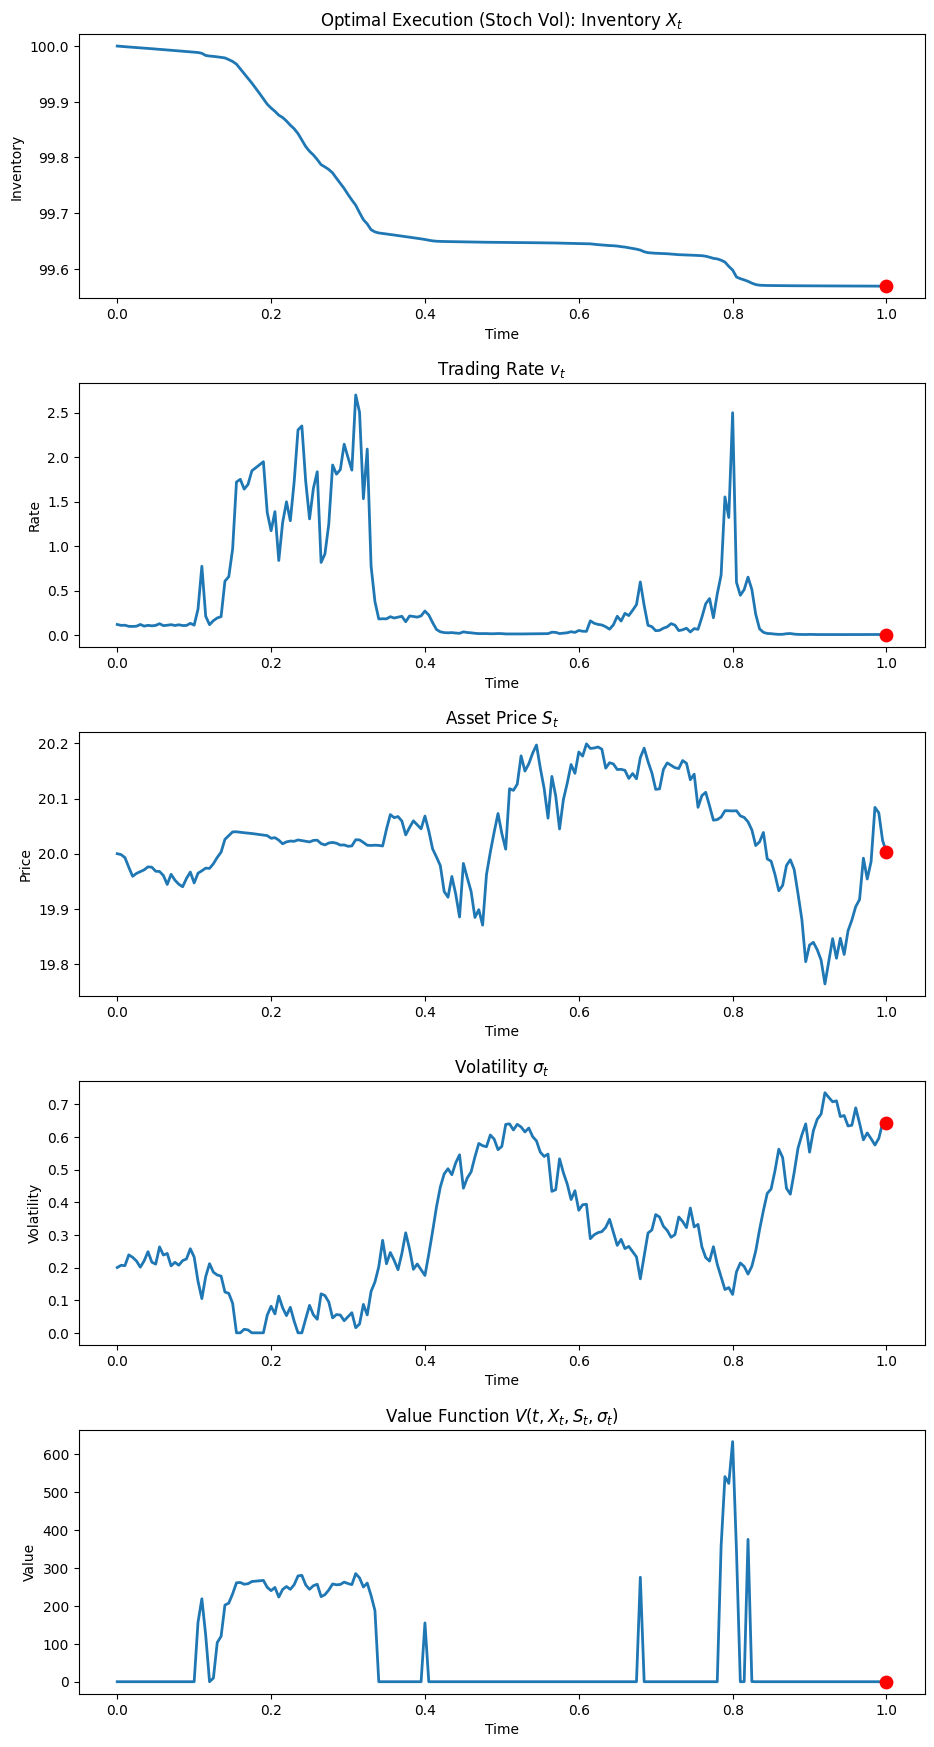

In [16]:
# Actor–Critic PINN for Optimal Execution with Stochastic Vol

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import time

# device & problem constants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INIT_X = 100.0 #100.0    # inventory scale 
S_SCALE = 20.0    # price scale 
SIG_SCALE = 0.2   # volatility scale 
T_final = 1.0     # horizon 
X_target = 0.0    # terminal target inventory

# maximum trading rate to scale policy output to physical units
MAX_RATE = 350.0 #350.0

# model spec (MLP helper)
def MLP(input_dim, hidden_dims=(128,128,128), output_dim=1,
        activation=nn.Tanh, final_activation=None):
    layers = []
    dims = [input_dim] + list(hidden_dims)
    for i in range(len(hidden_dims)):
        layers.append(nn.Linear(dims[i], dims[i+1]))
        layers.append(activation())
    layers.append(nn.Linear(dims[-1], output_dim))
    if final_activation is not None:
        # allow classes nn.Softplus or functions
        if callable(final_activation):
            layers.append(final_activation())
        else:
            layers.append(final_activation)
    return nn.Sequential(*layers)

IN_DIM = 4  # normalized state space (t/T, X/INIT_X, S/S_SCALE, sigma/SIG_SCALE)

# ScaledValue wrapper

import torch.nn.functional as F

class ScaledValue(nn.Module):
    def __init__(self, base_net):
        super().__init__()
        self.base = base_net
        self.scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        return F.softplus(self.scale * self.base(x))

# Olde version without softplus , value_net_scale = 74.0 under stochastic output 5
# class ScaledValue(nn.Module):
   # def __init__(self, base_net):
       # super().__init__()
       # self.base = base_net
       # self.scale = nn.Parameter(torch.tensor(1.0))  

   # def forward(self, x):
       # return self.scale * self.base(x)

# value network, outputs V in physical units, wrapped with scale
value_net = ScaledValue(
    MLP(IN_DIM, hidden_dims=(128,128,128), output_dim=1, final_activation=None)
).to(device)

# policy network, outputs nonnegative scalar in [0, +inf) in normalized units.
policy_net = MLP(IN_DIM, hidden_dims=(128,128), output_dim=1, final_activation=nn.Softplus).to(device)

actor_opt = optim.Adam(policy_net.parameters(), lr=3e-4)
critic_opt = optim.Adam(value_net.parameters(), lr=3e-4)

# scale value network to start with reasonable magnitude
with torch.no_grad():
    value_net.scale.data.fill_(109.0)

# initialize policy network final layer bias
nn.init.constant_(policy_net.base[-1].bias if isinstance(policy_net, ScaledValue) else policy_net[-2].bias, 0.1)


# PDE, model params
eta = 0.1
lam = 0.1
kappa = 2.0
theta_bar = 0.2
xi = 0.6
rho = -0.5

# gradient functions
def grads(outputs, inputs, create_graph=True):
    return torch.autograd.grad(outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=create_graph, retain_graph=True)[0]

def second_derivative_scalar_wrt(inputs, outputs, idx):
    g = grads(outputs, inputs, create_graph=True)
    return torch.autograd.grad(g[:, idx].sum(), inputs, retain_graph=True)[0][:, idx:idx+1]

# normalization function
def normalize_state(s_raw):
    # s_raw represents (t, X, S, sigma)  
    t = s_raw[..., 0:1] / T_final
    X = s_raw[..., 1:2] / INIT_X
    S = s_raw[..., 2:3] / S_SCALE
    sig = s_raw[..., 3:4] / SIG_SCALE
    return torch.cat([t, X, S, sig], dim=-1)

# sampling functions 
def sample_collocation(batch_size):
    # bias t toward terminal to help terminal loss 
    t = (torch.rand(batch_size,1) ** 2) * T_final
    X = torch.rand(batch_size,1) * INIT_X         
    S = torch.randn(batch_size,1) * S_SCALE      
    sigma = torch.rand(batch_size,1) * 0.8 + 0.05   
    return torch.cat([t,X,S,sigma], dim=1).to(device)

def sample_terminal(batch_size):
    t = torch.ones(batch_size,1) * T_final
    X = torch.rand(batch_size,1) * INIT_X
    S = torch.randn(batch_size,1) * S_SCALE
    sigma = torch.rand(batch_size,1) * 0.8 + 0.05
    return torch.cat([t,X,S,sigma], dim=1).to(device)

# Value function derivatives 
def compute_value_derivatives(s_raw, value_net):
    s_norm = normalize_state(s_raw)
    s_norm = s_norm.clone().detach().requires_grad_(True)

    V = value_net(s_norm)          
    g = grads(V, s_norm, create_graph=True)
    Vt = g[:,0:1]  / T_final
    VX = g[:,1:2]  / INIT_X
    VS = g[:,2:3]  / S_SCALE
    Vsig = g[:,3:4] / SIG_SCALE

    VSS_norm = second_derivative_scalar_wrt(s_norm, V, idx=2)
    VSS = VSS_norm / (S_SCALE**2)
    Vssig_norm = second_derivative_scalar_wrt(s_norm, V, idx=3)
    Vssig = Vssig_norm / (SIG_SCALE**2)
    VS_grad = g[:,2:3]
    VSsigma = torch.autograd.grad(VS_grad.sum(), s_norm, retain_graph=True)[0][:,3:4] / SIG_SCALE

    return V, Vt, VX, VS, Vsig, VSS, Vssig, VSsigma, s_norm

# Hamiltonian
def hamiltonian(s_raw, v, V_X, V_S):
    return - v * V_X - eta * v * V_S + 0.5 * lam * v**2

# training network parameters
n_epochs = 2000
pretrain_epochs = 300
actor_warmup_epochs = 200
batch_colloc = 1200
batch_term = 1200
actor_steps = 5
critic_steps = 20

# weights
w_res_base = 100.0
w_term_base = 1.0
w_cons_base = 0.5

# regularizer to clip gradients
grad_reg_weight = 1.0 #1e-6

# Polyak
value_target = copy.deepcopy(value_net)
polyak_tau = 0.995

# supervised pretrain value_net on terminal condition
print("Device:", device)
print("Starting supervised pretraining of value_net on terminal condition...")
start_time = time.time()
mse = nn.MSELoss()

for e in range(pretrain_epochs):
    s_term = sample_terminal(batch_term)                   
    X_T = s_term[:,1:2]
    target = 0.5 * (X_T - X_target)**2                     
    s_term_norm = normalize_state(s_term)                  
    Vpred = value_net(s_term_norm)                         
    loss = mse(Vpred, target)
    critic_opt.zero_grad()
    loss.backward()
    critic_opt.step()
    if e % 50 == 0:
        print(f"Pretrain {e}/{pretrain_epochs} loss={loss.item():.6e}")
print("Pretrain finished. Time:", time.time()-start_time)

# joint training loop (actor-critic)
print("Starting joint actor-critic training...")
for epoch in range(n_epochs):
    # scheduling weights, ramp up terminal weight with time
    w_term = 0.01 + 0.99 * min(1.0, epoch / 800.0)  
    w_res = w_res_base
    w_cons = 0.0 if epoch < actor_warmup_epochs else w_cons_base

    # actor updates, supervised toward analytic v*
    if epoch >= actor_warmup_epochs:
        for _ in range(actor_steps):
            s_batch = sample_collocation(batch_colloc)           

            # critic derivatives, debug prints
            V, Vt, VX, VS, Vsig, VSS, Vssig, VSsigma, s_norm = compute_value_derivatives(
                s_batch, value_net
            )

            if epoch % 100 == 0 or epoch < 5:
                print("\n[DEBUG epoch", epoch, "]")
                print("  V mean:", V.mean().item())
                print("  |VX| mean:", VX.abs().mean().item())
                print("  |VS| mean:", VS.abs().mean().item())
                print("  |VSS| mean:", VSS.abs().mean().item())
                print("  |Vsig| mean:", Vsig.abs().mean().item())
                print("  |VSsigma| mean:", VSsigma.abs().mean().item())
                print("  S mean:", s_batch[:,2:3].mean().item())
                print("  sigma mean:", s_batch[:,3:4].mean().item())

                vstar_dbg = torch.clamp(-(VX + eta*VS)/lam, min=0)
                print("  v* min/mean/max:",
                  vstar_dbg.min().item(),
                  vstar_dbg.mean().item(),
                  vstar_dbg.max().item())


            # analytic optimal control:
            # v* = max(0,  (VX + eta*VS)/lam  )
            v_star = (VX + eta * VS) / lam
            v_star = torch.clamp(v_star, min=0.0)   

            # normalize target for actor 
            v_star_norm = v_star / MAX_RATE
            v_star_norm = torch.clamp(v_star_norm, 0.0, 10.0)

            # normalized policy raw output
            s_in = s_norm.detach()
            pi_raw = policy_net(s_in)        

            # supervised actor loss
            actor_loss_scale = 100000000.0
            actor_loss = ((pi_raw - v_star_norm.detach())**2).mean()
            actor_loss = (actor_loss + 1e-6 * (pi_raw**2).mean()) * actor_loss_scale

            actor_opt.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 5.0)
            actor_opt.step()

    else:
        actor_loss = torch.tensor(0.0, device=device)


    # critic updates
    for _ in range(critic_steps):
        s_col = sample_collocation(batch_colloc)           
        V, Vt, VX, VS, Vsig, VSS, Vssig, VSsigma, s_norm = compute_value_derivatives(s_col, value_net)

        # policy evaluation, feed normalized states to policy
        with torch.no_grad():
            pi_raw_det = policy_net(s_norm)                 
            pi_det = pi_raw_det * MAX_RATE               

        # PDE terms
        diffusion = 0.5 * (s_col[:,3:4]**2) * VSS
        meanrev  = kappa * (theta_bar - s_col[:,3:4]) * Vsig
        volvol   = 0.5 * xi**2 * Vssig
        cross    = rho * xi * s_col[:,3:4] * VSsigma

        H_val = hamiltonian(s_col, pi_det, VX, VS)
        R = Vt + diffusion + meanrev + volvol + cross + H_val
        L_res = (R**2).mean()

        # terminal loss 
        s_term = sample_terminal(batch_term)
        s_term_norm = normalize_state(s_term)
        V_term = value_net(s_term_norm)                    
        X_T = s_term[:,1:2]
        terminal_target = 0.5 * (X_T - X_target)**2
        L_term_raw = ((V_term - terminal_target)**2).mean()
        L_term = w_term * L_term_raw

        # consistency penalty, i.e. actor vs analytic control from critic
        _, _, VXf, VSf, _, _, _, _, _ = compute_value_derivatives(s_col, value_net)
        pi_hat = (VXf + eta * VSf) / lam
        pi_hat = torch.clamp(pi_hat, min=0.0)          

        # compare in normalized space the actor raw output vs normalized analytic
        pi_pred_raw = policy_net(normalize_state(s_col).detach())   
        pi_hat_norm = pi_hat / MAX_RATE
        L_cons = ((pi_pred_raw - pi_hat_norm.detach())**2).mean()

        # gradient regularizer
        grad_reg = (VX.pow(2).mean() + VS.pow(2).mean())
        L_grad = grad_reg_weight * grad_reg

        critic_loss_scale = 0.001
        critic_loss = (w_res * L_res + L_term + w_cons * L_cons + L_grad) * critic_loss_scale

        critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_net.parameters(), 5.0)
        critic_opt.step()

        # polyak update
        for p, pt in zip(value_net.parameters(), value_target.parameters()):
            pt.data.mul_(polyak_tau)
            pt.data.add_((1.0 - polyak_tau) * p.data)

    # print diagnostics every 100 epochs
    if epoch % 100 == 0 or epoch < 10:
        s_dbg = sample_collocation(256)
        V_dbg, Vt_dbg, VX_dbg, VS_dbg, _, _, _, _, sdbg_norm = compute_value_derivatives(s_dbg, value_net)
        vstar_dbg = (VX_dbg + eta * VS_dbg) / lam
        vstar_dbg = torch.clamp(vstar_dbg, min=0.0)
        with torch.no_grad():
            pi_dbg = policy_net(normalize_state(s_dbg)) * MAX_RATE
        print(f"Epoch {epoch:5d} | actor_loss={actor_loss.item():.3e} critic_loss={critic_loss.item():.3e} "
              f"res={L_res.item():.3e} term={L_term.item():.3e} cons={L_cons.item():.3e} grad_reg={grad_reg.item():.3e} "
              f"mean|v*|={vstar_dbg.abs().mean().item():.6e} mean|pi|={pi_dbg.abs().mean().item():.6e}")

# simulation using trained policy and value network
def simulate_policy(n_steps=200, X0=INIT_X, S0=S_SCALE, sigma0=SIG_SCALE, seed=None):
    if seed is not None:
        torch.manual_seed(seed)

    dt = float(T_final) / n_steps
    sqrt_dt = torch.sqrt(torch.tensor(dt, device=device))
    t_grid = torch.linspace(0, T_final, n_steps+1, device=device)

    # state paths
    X     = torch.zeros(n_steps+1, device=device)
    S     = torch.zeros(n_steps+1, device=device)
    sigma = torch.zeros(n_steps+1, device=device)
    v     = torch.zeros(n_steps+1, device=device)
    Vvals = torch.zeros(n_steps+1, device=device)

    # initialize state
    X[0], S[0], sigma[0] = X0, S0, sigma0

    # evaluate value at t = 0
    with torch.no_grad():
        s0 = torch.cat([t_grid[0].reshape(1,1),
                        X[0].reshape(1,1),
                        S[0].reshape(1,1),
                        sigma[0].reshape(1,1)], dim=1)
        Vvals[0] = value_net(normalize_state(s0)).item()

    # main iteratave loop
    for k in range(n_steps):

        # build state (t_k, X_k, S_k, sigma_k)
        state_raw = torch.cat([
                    t_grid[k].reshape(1,1),
                    X[k].reshape(1,1),
                    S[k].reshape(1,1),
                    sigma[k].reshape(1,1)], dim=1)
        state_norm = normalize_state(state_raw)

        # policy evaluation
        with torch.no_grad():
            pi_raw = policy_net(state_norm).view(-1)
            pi_val = float(pi_raw.item() * MAX_RATE)

        # action constraints
        # must be >= 0
        pi_val = max(0.0, pi_val)

        # prevent oversell, i.e. enforce X_{k+1} >= 0
        max_possible = max(0.0, float((X[k].item() - 1e-8) / dt))
        pi_val = min(pi_val, max_possible)

        # enforce max rate bound
        pi_val = min(pi_val, MAX_RATE)

        v[k] = pi_val

        # correlated brownian increments
        dW_S = torch.randn(1, device=device) * sqrt_dt
        dW_sigma_indep = torch.randn(1, device=device) * sqrt_dt
        dW_sigma = rho * dW_S + torch.sqrt(torch.tensor(1.0 - rho**2, device=device)) * dW_sigma_indep

        # state updates
        X[k+1]     = X[k] - v[k] * dt
        S[k+1]     = S[k] - eta * v[k] * dt + sigma[k] * dW_S
        sigma[k+1] = sigma[k] + kappa*(theta_bar - sigma[k]) * dt + xi * dW_sigma
        if sigma[k+1] < 0:
            sigma[k+1] = torch.tensor(0.0, device=device)

        # numerical safety clamp
        if X[k+1] < 0:
            X[k+1] = 0.0

        # evaluate value function at the updated state
        next_raw = torch.cat([
                    t_grid[k+1].reshape(1,1),
                    X[k+1].reshape(1,1),
                    S[k+1].reshape(1,1),
                    sigma[k+1].reshape(1,1)], dim=1)
        next_norm = normalize_state(next_raw)

        with torch.no_grad():
            Vvals[k+1] = value_net(next_norm).item()

    return (
        t_grid.cpu().numpy(),
        X.cpu().numpy(),
        S.cpu().numpy(),
        sigma.cpu().numpy(),
        v.cpu().numpy(),
        Vvals.cpu().numpy(),
    )

import matplotlib.pyplot as plt
import numpy as np

def plot_simulation_results(t, X, S, sigma, v, Vvals, title_prefix="Simulation Results"):
    # stop plotting once inventory reaches zero
    idx = np.argmax(X <= 0)
    if X[idx] > 0:        
        idx = len(X)

    # slice the trajectories, dont plot past liquidated inventory
    t_plot      = t[:idx]
    X_plot      = X[:idx]
    S_plot      = S[:idx]
    sigma_plot  = sigma[:idx]
    v_plot      = v[:idx]
    Vvals_plot  = Vvals[:idx]

    # liquidation time indicator
    t_liq = t_plot[-1]

    fig, axs = plt.subplots(5, 1, figsize=(10, 18))
    fig.tight_layout(pad=4.0)

    # inventory X_t
    axs[0].plot(t_plot, X_plot, linewidth=2)
    axs[0].scatter([t_liq], [X_plot[-1]], color="red", s=80, zorder=5)
    axs[0].set_title(f"{title_prefix}: Inventory $X_t$")
    axs[0].set_xlabel("Time"); axs[0].set_ylabel("Inventory")

    # trading rate v_t
    axs[1].plot(t_plot, v_plot, linewidth=2)
    axs[1].scatter([t_liq], [v_plot[-1]], color="red", s=80, zorder=5)
    axs[1].set_title("Trading Rate $v_t$")
    axs[1].set_xlabel("Time"); axs[1].set_ylabel("Rate")

    # asset price
    axs[2].plot(t_plot, S_plot, linewidth=2)
    axs[2].scatter([t_liq], [S_plot[-1]], color="red", s=80, zorder=5)
    axs[2].set_title("Asset Price $S_t$")
    axs[2].set_xlabel("Time"); axs[2].set_ylabel("Price")



    # volatility sigma_t
    axs[3].plot(t_plot, sigma_plot, linewidth=2)
    axs[3].scatter([t_liq], [sigma_plot[-1]], color="red", s=80, zorder=5)
    axs[3].set_title("Volatility $\\sigma_t$")
    axs[3].set_xlabel("Time"); axs[3].set_ylabel("Volatility")

    # value function
    axs[4].plot(t_plot, Vvals_plot, linewidth=2)
    axs[4].scatter([t_liq], [Vvals_plot[-1]], color="red", s=80, zorder=5)
    axs[4].set_title("Value Function $V(t, X_t, S_t, \\sigma_t)$")
    axs[4].set_xlabel("Time"); axs[4].set_ylabel("Value")

    plt.show()




t, X, S, sigma, v, Vvals = simulate_policy(
    n_steps=200,
    X0=INIT_X,
    S0=S_SCALE,
    sigma0=SIG_SCALE,
    seed=123
)

plot_simulation_results(t, X, S, sigma, v, Vvals, title_prefix="Optimal Execution (Stoch Vol)")









